In [2]:
#Get csv data from API price per sq.ft Dataframe 

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

df = pd.read_csv("ZillowData/ZillowData2.csv")

# Remove unwanted observations
df = df.drop(["property_size","last_sold_date","zestimate_amount","last_sold_price","Property Address","Geographic ID","Type","Property ID","Owner Name","zillow_id","Appraisel_Year","tax_year","tax_value"], axis=1)
df = df.loc[df["home_type"]== "SingleFamily",:]
df["Appraised Value"]=df["Appraised Value"].replace({'\$': '', ',': ''}, regex=True)
df["best_estimate_$perFt"] = df["best_estimate_$perFt"].dropna(how = 'any', axis = 0)
df = df[pd.notnull(df["bedrooms"])]
df = df[pd.notnull(df["bathrooms"])]
df = df[pd.notnull(df["best_estimate_$perFt"])]
df = df[pd.notnull(df["year_built"])]
df = df.loc[df["bedrooms"] > 0,:]
df = df.loc[df["bathrooms"] > 0,:]

# Fix Structural Errors 
df.reset_index(inplace=True)
df = df.drop(["index"], axis=1)
df["year_built"] = df["year_built"].astype(int)
df["home_size"] = df["home_size"].astype(int)

df.head(5)

,Appraised Value,Zip,home_type,year_built,home_size,bathrooms,bedrooms,best_estimate,best_estimate_$perFt
0,688000,78702,SingleFamily,2008,1680,2.0,3.0,688000,409.53
1,417950,78702,SingleFamily,1943,1390,2.0,4.0,721234,518.88
2,523600,78702,SingleFamily,1962,1343,2.0,2.0,523600,389.88
3,451996,78702,SingleFamily,1964,1224,2.0,4.0,464047,379.13
4,605634,78702,SingleFamily,1940,1699,2.0,4.0,605634,356.47


In [3]:
#Identify and Remove Sq Ft Outliers
sort_sqft = df.sort_values("best_estimate_$perFt", ascending = False)

sqft = sort_sqft["best_estimate_$perFt"].tolist()

Q1,Q3 = np.percentile(sqft,[25,75])
iqr = Q3 - Q1
lower_limit = Q1 - (1.5 * iqr)
upper_limit = Q3 + (1.5 * iqr)

sort_sqft = sort_sqft.loc[sort_sqft["best_estimate_$perFt"] <= upper_limit,:]
sort_sqft = sort_sqft.loc[sort_sqft["best_estimate_$perFt"] >= lower_limit,:]

#sort_sqft["best_estimate_$perFt"].describe()
zipdf = sort_sqft.groupby(["Zip"], as_index=False).agg({'best_estimate':'mean','best_estimate_$perFt': 'mean'})
zipdf.head(5)

,Zip,best_estimate,best_estimate_$perFt
0,78702,517084.466102,390.026379
1,78745,353142.324480,242.488485


In [6]:
# Bin Years Built
sort_yr = sort_sqft.sort_values("year_built", ascending = False)

bins = [0,1919,1940,1960,1980,2000,2020]
timeframes = ["Pre 1920's","1920-1940","1941-1960","1961-1980","1981-2000","2000-Present"]

sort_yr["Built Timeframe"] = pd.cut(sort_yr["year_built"],bins, labels=timeframes)

#sizeyr = sort_yr.groupby(["Zip","Built Timeframe"], as_index=False).agg({'year_built' : 'count','bedrooms' : 'mean','home_size':'mean','best_estimate_$perFt': 'mean','best_estimate':'mean'})
#sizeyr.head(20)

sizeyr2 = sort_yr.groupby(["Zip","Built Timeframe"], as_index=False).agg({'year_built' : 'count','home_size':'mean','best_estimate_$perFt': 'mean','best_estimate':'mean'})
sizeyr2.head(50)

,Zip,Built Timeframe,year_built,home_size,best_estimate_$perFt,best_estimate
0,78702,Pre 1920's,77,1405.688312,420.084286,564369.324675
1,78702,1920-1940,321,1177.121495,431.577352,480183.423676
2,78702,1941-1960,304,1158.065789,397.669441,430683.582237
3,78702,1961-1980,65,1244.815385,394.278923,465817.676923
4,78702,1981-2000,88,1309.602273,378.106364,485601.784091
5,78702,2000-Present,443,1789.826185,351.192822,608671.343115
6,78745,Pre 1920's,2,2337.500000,211.645000,489902.000000
7,78745,1920-1940,6,1063.166667,348.333333,339068.000000
8,78745,1941-1960,132,1339.318182,304.003939,384557.530303
9,78745,1961-1980,874,1427.176201,245.274977,340422.564073


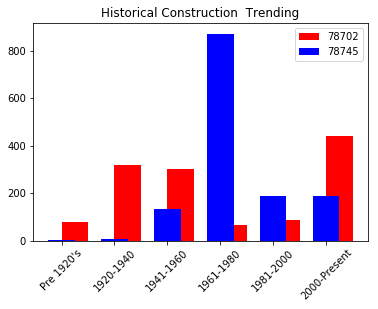

<Figure size 1440x720 with 0 Axes>

In [7]:
age = sizeyr2.drop(["home_size","best_estimate_$perFt",'best_estimate'], axis=1)
df78702 = age.loc[age["Zip"]== 78702,:]
df78745 = age.loc[age["Zip"]== 78745,:]

built02 = df78702['year_built'].tolist()
built45 = df78745['year_built'].tolist()

x1 = age["Built Timeframe"].unique()
x_Axis = x1.tolist()

plt.bar(x_Axis, built02, align='edge', color='r', label='78702', width = 0.5)
plt.bar(x_Axis, built45, align='center',  color='b', label='78745', width = 0.5)
plt.xticks(rotation=45)
plt.legend()
plt.title("Historical Construction  Trending")
plt.figure(figsize=(20,10))
plt.show()


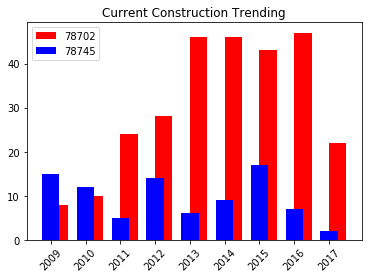

<Figure size 1440x720 with 0 Axes>

In [8]:
current = sort_yr.loc[sort_yr["year_built"]>= 2009,:]
current = current.loc[current["year_built"]<= 2017,:]
c2 = current.copy()
c2["year_built"] = c2["year_built"].astype(int)
c2 = c2.sort_values("year_built", ascending = True)
current2 = c2.groupby(["Zip","year_built"], as_index=False).agg({'Built Timeframe' : 'count'})


current78702 = current2.loc[current2["Zip"]== 78702,:]
current78745 = current2.loc[current2["Zip"]== 78745,:]
current02 = current78702['Built Timeframe'].astype(int).tolist()
current45 = current78745['Built Timeframe'].astype(int).tolist()


X2 = current78702['year_built'].unique()
X_axis2 = X2.tolist()
X3 = current78745['year_built'].unique()
X_axis3 = X3.tolist()

plt.bar(X_axis2, current02, align='edge', color='r', label='78702', width = 0.5)
plt.bar(X_axis3, current45, align='center',color='b', label='78745', width = 0.5)
plt.xticks(X_axis2,rotation=45)
plt.legend()
plt.title("Current Construction Trending")
plt.figure(figsize=(20,10))
plt.show()